<a href="https://colab.research.google.com/github/debyyamamoto/atividades_rec_musical/blob/main/C%C3%B3pia_de_Aula_12_CNNs_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descomente para executar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-4tfjp9oy
  Running command git clone --filter=blob:none --quiet https://github.com/flaviovdf/musica.git /tmp/pip-req-build-4tfjp9oy
  Resolved https://github.com/flaviovdf/musica.git to commit 32d10fd5de31f283bf5d9484a43cba67b605b16c
  Preparing metadata (setup.py) ... done


# Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems.

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [ ]:
from musica import mu_files
from musica import mu_plots

from glob import glob

import flax.linen as nn
import jax.numpy as jnp
import jax

import librosa
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import pandas as pd

In [ ]:
mu_files.download('https://dcc.ufmg.br/~flaviovdf/mir/lab07/files.zip', 'files.zip',
             False)
mu_files.extract('files.zip', '.')

files.zip: 300MB [00:34, 9.20MB/s]


In [ ]:
mu_plots.init_matplotlib()
plt.ion()

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [ ]:
df = pd.read_csv('subset_magnatune.csv', index_col=0)
df.shape

(1048, 189)

In [ ]:
df.head()

,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,clasical,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/american_bach_soloists-j_s__bach__cantatas_v...
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0/rocket_city_riot-last_of_the_pleasure_seeker...
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-59-88.npy
294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c/strojovna_07-number_1-01-ambi_crack-88-117.npy
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-01-ambient_teknolo...


[Text(0, 0.5, 'Frequência')]

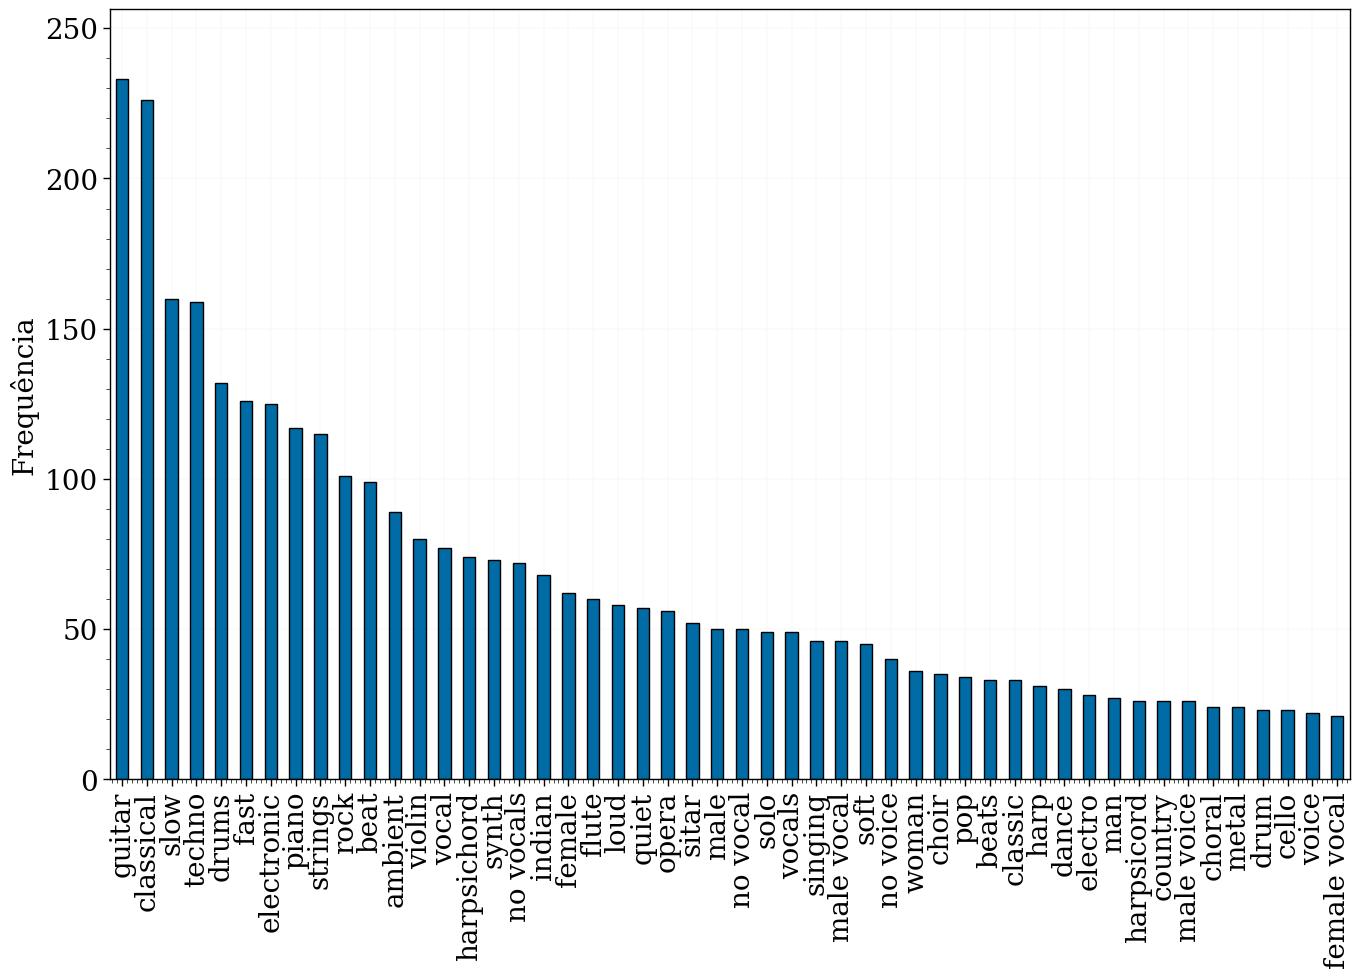

In [ ]:
_, ax = plt.subplots(1, 1)
(df.iloc[:, :-1].sum().
 sort_values(ascending=False)[:50].
 plot.bar(ax=ax, rot=90, edgecolor='k')
)
ax.set(ylabel='Frequência')

In [ ]:
top = (df.iloc[:, :-1].sum().
       sort_values(ascending=False)[:50]).index
top

Index(['guitar', 'classical', 'slow', 'techno', 'drums', 'fast', 'electronic',
       'piano', 'strings', 'rock', 'beat', 'ambient', 'violin', 'vocal',
       'harpsichord', 'synth', 'no vocals', 'indian', 'female', 'flute',
       'loud', 'quiet', 'opera', 'sitar', 'male', 'no vocal', 'solo', 'vocals',
       'singing', 'male vocal', 'soft', 'no voice', 'woman', 'choir', 'pop',
       'beats', 'classic', 'harp', 'dance', 'electro', 'man', 'harpsicord',
       'country', 'male voice', 'choral', 'metal', 'drum', 'cello', 'voice',
       'female vocal'],
      dtype='object')

In [ ]:
df = df[[c for c in top] + ['mp3_path']]
df.shape

(1048, 51)

Essa função serve para determinar se existe algum atributo com uma coluna só de zeros

In [ ]:
(df.drop(columns = ['mp3_path']).sum(axis=1)== 0).any()

True

O objetivo aqui é remover linhas "vazias"

In [ ]:
df = df[df.drop(columns=['mp3_path']).sum(axis=1) != 0]
df = df.sample(frac=1) #isso aqui embaralha as linhas para evitar qualquer viés do df original
df.head()

,guitar,classical,slow,techno,drums,fast,electronic,piano,strings,rock,...,harpsicord,country,male voice,choral,metal,drum,cello,voice,female vocal,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
20833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d/paul_avgerinos-words_touch-04-words_touch-14...
42774,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2/version-versions-10-gardens_of_utopia-175-20...
25383,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1/ambient_teknology-phoenix-05-war_and_sleep-1...
42144,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,c/the_art_of_the_lute_player-the_art_of_the_lu...
33448,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,a/falling_you-human-07-starshine-204-233.npy


Dividiu a base em treino, validação e teste

In [ ]:
train_df = df[:768]
val_df = df[768:896]
test_df = df[896:896+128]

print(train_df.shape, val_df.shape, test_df.shape)

(768, 51) (128, 51) (128, 51)


# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [ ]:
def to_mel_spectrum(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
    S = librosa.feature.melspectrogram(y=wave[:secs * sr],
                                       sr=sr,
                                       n_fft=n_fft,
                                       n_mels=n_mels)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [ ]:
def load_data(file_paths):
    for fpath in file_paths:
        fpath = os.path.join('waveform', fpath)
        yield np.load(fpath)

In [ ]:
data_train = list(map(to_mel_spectrum, load_data(train_df['mp3_path'])))
X_train = jnp.array(data_train)
Y_train = jnp.array(train_df.drop('mp3_path', axis=1).values)

data_val = list(map(to_mel_spectrum, load_data(val_df['mp3_path'])))
X_val = jnp.array(data_val)
Y_val = jnp.array(val_df.drop('mp3_path', axis=1).values)

data_test = list(map(to_mel_spectrum, load_data(test_df['mp3_path'])))
X_test = jnp.array(data_test)
Y_test = jnp.array(test_df.drop('mp3_path', axis=1).values)

## Iterating in Batches

In [ ]:
batch_size = 16
X_batches = X_train.reshape((X_train.shape[0] // batch_size,
                             batch_size,
                             X_train.shape[1],
                             X_train.shape[2]))
Y_batches = Y_train.reshape((Y_train.shape[0] // batch_size,
                             batch_size,
                             Y_train.shape[1]))

In [ ]:
Xb, Yb = X_batches[0], Y_batches[0]
Xb.shape

(16, 96, 188)

In [ ]:
Yb.shape

(16, 50)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

A classe Baseline define a arquitetura convolucional com o uso da biblioteca Flax.

- Dúvidas:
  - pq call? o Método __call__ permite que uma instância de uma classe seja chamada como uma função.
  - Qual a função de ReLU? A função de ativação é usada depois das camadas convolucionais porque melhora o aprendizado da rede neural ao introduzir não linearidade.
  - A função RELU é definida da seguinte forma:
  $$
    f(x) = max(0,x)
  $$
    - Se a saída da convolução for positiva, mantém o valor.
    - Se for negativa, substitui por zero.
    - Assim ela garante que apenas atividades relevantes sejam passadas para a camada seguinte.

In [ ]:
class Baseline(nn.Module):
    @nn.compact
    def __call__(self, x):
      # aqui indica que três camadas convolucionais são implementadas com max  pooling
        for _ in range(3): # loop para três camadas convolucionais
            x = nn.Conv(96, kernel_size=(3, ), strides=(1, ))(x) # convolução
            x = nn.relu(x) #função de ativação ReLU
            x = nn.max_pool(x, window_shape=(3, ), strides=(1, ))
        # pooling global
        x = nn.avg_pool(x, window_shape=(1, ))
        # flatten para vetorizar os dados
        x = x.reshape((x.shape[0], -1))  # flatten
        # camada densa para classificação
        x = nn.Dense(50)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
model = Baseline() #cria uma instância do modelo
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape)) #inicia os parâmetros usando uma semente aleatória

In [ ]:
logits = Baseline().apply(variables, Xb)
logits.shape #saida bruta do modelo

(16, 50)

In [ ]:
@jax.jit
def cross_entropy_loss(logits, Yb):
    return -jnp.mean(jnp.sum(Yb * logits, axis=-1))

In [ ]:
logits = Baseline().apply(variables, Xb)
cross_entropy_loss(logits, Yb)

Array(47.80497, dtype=float32)

In [ ]:
logits = Baseline().apply(variables, X_train)
cross_entropy_loss(logits, Y_train)

Array(64.916245, dtype=float32)

In [ ]:
logits = Baseline().apply(variables, X_val)
cross_entropy_loss(logits, Y_val)

Array(67.083176, dtype=float32)

In [ ]:
logits = Baseline().apply(variables, X_test)
cross_entropy_loss(logits, Y_test)

Array(57.42679, dtype=float32)

In [ ]:
@jax.jit
def train_step(Xb, Yb, state):
    def loss_fn(params):
        logits = Baseline().apply({'params': params}, Xb)
        loss = cross_entropy_loss(logits, Yb)
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [ ]:
from flax.training import train_state

model = Baseline()
variables = model.init(jax.random.PRNGKey(0), jnp.ones(Xb.shape))

lr = 0.0005
iter = 50

params = variables['params']
tx = optax.sgd(learning_rate=lr)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=tx)
for i in range(iter):
    for Xb, Yb in zip(X_batches, Y_batches):
        state = train_step(Xb, Yb, state)
    train_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                     X_train),
                                    Y_train)
    val_loss = cross_entropy_loss(Baseline().apply({'params': state.params},
                                                   X_val),
                                  Y_val)
    if i % 10 == 0:
        print('Iter: {}; Train Loss {}; Val Loss = {}'.format(i, train_loss,
                                                              val_loss))

Iter: 0; Train Loss 12.444839477539062; Val Loss = 12.501258850097656
Iter: 10; Train Loss 10.12889289855957; Val Loss = 11.256410598754883
Iter: 20; Train Loss 8.775527000427246; Val Loss = 11.391938209533691
Iter: 30; Train Loss 7.653071880340576; Val Loss = 11.869006156921387
Iter: 40; Train Loss 6.843666076660156; Val Loss = 12.671680450439453


In [ ]:
def auto_tagging(id, df, X, model, params, topk):
    row = df.iloc[id].copy()
    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))

    X = jnp.array([X[id]])
    logit = model().apply({'params': params}, X)[0]
    idx = logit.argsort()[-topk:][::-1]

    return wave, row.index[idx]


In [ ]:
import IPython.display as ipd

id = 30
wave, tags = auto_tagging(id, test_df, X_test, Baseline, state.params, 5)
print(tags)
ipd.Audio(wave, rate=16000) # load a NumPy array

Index(['drums', 'fast', 'female', 'woman', 'techno'], dtype='object')


In [ ]:
import os
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
import librosa
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings!

- Agora, vamos fazer algo similar a ideia acima, mas com sinais 2D (frequência de tempo).

**Data Processing**

Aqui nós vamos processar o áudio e convertê-los em espectogramas Mel

Em Pytorch -> fazemos uso de tensores que são muito parecidos com as listas de numpy.

In [ ]:
def para_mel_espectograma(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
  transform = torchaudio.transforms.MelSpectrogram(
      sample_rate = sr,
      n_fft = n_fft,
      n_mels = n_mels
  )
  wave = wave[:secs * sr]
  if not isinstance(wave, torch.Tensor):
    wave = torch.tensor(wave, dtype=torch.float32)
  S = transform(wave)
  S_db = torchaudio.transforms.AmplitudeToDB()(S)
  return S_db

In [ ]:
def load_data(file_paths):
  for fpath in file_paths:
    fpath = os.path.join('waveform', fpath)
    yield torch.from_numpy(np.load(fpath)).float()

In [ ]:
data_train = [para_mel_espectograma(wave) for wave in load_data(train_df['mp3_path'])]
X_train = torch.stack(data_train)
Y_train = torch.tensor(train_df.drop('mp3_path', axis=1).values, dtype=torch.float32)

data_val = [para_mel_espectograma(wave) for wave in load_data(val_df['mp3_path'])]
X_val = torch.stack(data_val)
Y_val = torch.tensor(val_df.drop('mp3_path', axis=1).values, dtype=torch.float32)

data_test = [para_mel_espectograma(wave) for wave in load_data(test_df['mp3_path'])]
X_test = torch.stack(data_test)
Y_test = torch.tensor(test_df.drop('mp3_path', axis=1).values, dtype=torch.float32)

In [ ]:
X_train.shape

torch.Size([768, 96, 373])

**Separando os dados de treinamento em batches (mini lotes)**

In [ ]:
train_dataset = TensorDataset(X_train, Y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for batch_X, batch_Y in train_loader:
    print(batch_X.shape, batch_Y.shape)

torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([3

**Treinando Modelo**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Arquitetura(nn.Module):
    def __init__(self, n_mels=96, time_steps=94):
        super(Arquitetura, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))

        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 5), stride=(2, 5))

        with torch.no_grad():
            dummy_input = torch.randn(1, 1, n_mels, time_steps)
            dummy_output = self.forward_features(dummy_input)
            self.flatten_dim = dummy_output.view(-1).shape[0]

        self.fc = nn.Linear(self.flatten_dim, 50)

    def forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def cross_entropy_loss(logits, Yb):
  loss = nn.CrossEntropyLoss()(logits, Yb)
  return loss

In [ ]:
print(batch_X.shape)

torch.Size([32, 1, 96, 373])


In [ ]:
batch_size = 32
n_mels = 96
time_steps = 373

X_train = X_train.view(-1, 1, n_mels, time_steps)
X_val = X_val.view(-1, 1, n_mels, time_steps)
X_test = X_test.view(-1, 1, n_mels, time_steps)

model = Arquitetura(n_mels=n_mels, time_steps=time_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)

for epoch in range(10):
  model.train()
  total_loss = 0.0

  for batch_X, batch_Y in train_loader:
    optimizer.zero_grad()
    logits = model(batch_X)
    loss = cross_entropy_loss(logits, batch_Y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}")

Epoch 0, Loss: 12.067436257998148
Epoch 1, Loss: 11.182814598083496
Epoch 2, Loss: 10.850476582845053
Epoch 3, Loss: 10.647651036580404
Epoch 4, Loss: 10.438339312871298
Epoch 5, Loss: 10.26764969031016
Epoch 6, Loss: 10.13478704293569
Epoch 7, Loss: 9.953015526135763
Epoch 8, Loss: 9.785233298937479
Epoch 9, Loss: 9.534597913424173


In [ ]:
model = Arquitetura(n_mels=n_mels, time_steps=time_steps)

In [ ]:
X_test[30].numpy()

array([[[ 14.608093 ,   8.139682 ,   3.8350205, ...,  10.672598 ,
          14.797297 ,   6.564844 ],
        [ 17.595793 ,  11.12738  ,   6.8227196, ...,  13.660296 ,
          17.784994 ,   9.552544 ],
        [ 26.9687   ,  17.46249  ,  19.72561  , ...,  21.780521 ,
          24.59116  ,  19.201002 ],
        ...,
        [-19.867458 , -28.894112 , -34.63057  , ..., -30.300339 ,
         -31.92032  , -20.097158 ],
        [-31.541292 , -69.64334  , -73.61205  , ..., -67.75634  ,
         -69.71476  , -22.497885 ],
        [-39.956383 , -69.076164 , -73.60675  , ..., -68.498    ,
         -69.28821  , -23.069824 ]]], dtype=float32)

In [ ]:
def auto_tagging(id, df, X, model, topk):
    row = df.iloc[id].copy()
    audio_sample = [row['mp3_path']]
    row = row.drop('mp3_path')
    wave = next(load_data(audio_sample))

    X_input = torch.tensor(X[id], dtype=torch.float32).unsqueeze(0)
    device = next(model.parameters()).device
    X_input = X_input.to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X_input)

    _, top_indices = torch.topk(logits[0], k=topk)
    top_indices = top_indices.cpu().numpy()

    return wave.squeeze(), row.index[top_indices]

In [ ]:
id = 31
wave, tags = auto_tagging(id, test_df, X_test, model, 5)
print(tags)
ipd.Audio(wave, rate=16000)

Index(['male voice', 'synth', 'electro', 'indian', 'man'], dtype='object')


<ipython-input-176-d1b1269cca97>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(X[id], dtype=torch.float32).unsqueeze(0)


### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas:

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...).

* You can also use ResNet or other CNNs with skip connections.

* Furthermore, you can augment data using digital audio effects.

Beleza, agora preciso utilizar técnicas mais sofisticada para tentar obter melhores resultados


R:

In [ ]:
def para_mel_espectograma(wave, sr=16000, n_fft=516, n_mels=96, secs=6):
  transform = torchaudio.transforms.MelSpectrogram(
      sample_rate = sr,
      n_fft = n_fft,
      n_mels = n_mels
  )
  wave = wave[:secs * sr]
  if not isinstance(wave, torch.Tensor):
    wave = torch.tensor(wave, dtype=torch.float32)
  S = transform(wave)
  S_db = torchaudio.transforms.AmplitudeToDB()(S)
  return S_db

In [ ]:
def load_data(file_paths):
  for fpath in file_paths:
    fpath = os.path.join('waveform', fpath)
    yield torch.from_numpy(np.load(fpath)).float()

In [ ]:
data_train = [para_mel_espectograma(wave) for wave in load_data(train_df['mp3_path'])]
X_train = torch.stack(data_train)
Y_train = torch.tensor(train_df.drop('mp3_path', axis=1).values, dtype=torch.float32)

data_val = [para_mel_espectograma(wave) for wave in load_data(val_df['mp3_path'])]
X_val = torch.stack(data_val)
Y_val = torch.tensor(val_df.drop('mp3_path', axis=1).values, dtype=torch.float32)

data_test = [para_mel_espectograma(wave) for wave in load_data(test_df['mp3_path'])]
X_test = torch.stack(data_test)
Y_test = torch.tensor(test_df.drop('mp3_path', axis=1).values, dtype=torch.float32)

In [ ]:
X_train.shape

torch.Size([768, 96, 373])

In [ ]:
train_dataset = TensorDataset(X_train, Y_train)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for batch_X, batch_Y in train_loader:
    print(batch_X.shape, batch_Y.shape)

torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([32, 96, 373]) torch.Size([32, 50])
torch.Size([3

Para isso obtarei por fazer testes na arquitetura

- Vamos primeiro testar -> mudar os filtros
  - Os filtros em questão são filtros pequenos (capturam detalhes locais e padrões de baixa escala), se eu mudasse para grandes, ele reduzem a profundidade necessária da rede, vamos buscar usar filtros assimétricos
- Depois aumentamos a quantidade de filtros nas camadas mais profundas para capturar mais informações.
- Depois utilizamos uma técnica chamada Batch Normalization para estabilizar o aprendizado -> ela normalizada a ativação das camadas durante o treinamento, reduzindo o problema da explosão do gradiente e acelerando a convergência.
  Para cada mini-batch, a camada BN computa:
    - A média e desvio padrão das ativações.
    - Normaliza os valores para uma distribuição com média 0 e variância 1.
    - Aplica parâmetros de escala e deslocamento treináveis (γγ e ββ) para permitir que a rede recupere distribuições úteis.
- Por fim, aplicamos uma técnica chamada dropout para evitar overfitting -> ela desativa aleatoriamente neurônios durante o treinamento para evitar que a rede fique excessivamente dependente de padrões específicos dos dados de treino
  Durante o treinamento, cada neurônio tem uma probabilidade pp de ser desligado (neste caso, 30% dos neurônios são desativados). No teste, todos os neurônios são usados, mas os pesos são escalados para compensar o efeito do dropout.

In [ ]:
class Arquitetura2(nn.Module):
    def __init__(self, n_mels=96, time_steps=94, num_classes=50):
        super(Arquitetura2, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(1, 3), padding=(0, 1))
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=(3, 1), padding=(1, 0))
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))

        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 5), stride=(2, 5))

        self.dropout = nn.Dropout(0.3)

        with torch.no_grad():
            dummy_input = torch.randn(1, 1, n_mels, time_steps)
            dummy_output = self.forward_features(dummy_input)
            self.flatten_dim = dummy_output.view(-1).shape[0]

        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool4(x)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
batch_size = 32
n_mels = 96
time_steps = 373

X_train = X_train.view(-1, 1, n_mels, time_steps)
X_val = X_val.view(-1, 1, n_mels, time_steps)
X_test = X_test.view(-1, 1, n_mels, time_steps)

model = Arquitetura2(n_mels=n_mels, time_steps=time_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)

for epoch in range(10):
  model.train()
  total_loss = 0.0

  for batch_X, batch_Y in train_loader:
    optimizer.zero_grad()
    logits = model(batch_X)
    loss = cross_entropy_loss(logits, batch_Y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}")

Epoch 0, Loss: 11.796589652697245
Epoch 1, Loss: 10.971969763437906
Epoch 2, Loss: 10.582755963007608
Epoch 3, Loss: 10.294326623280844
Epoch 4, Loss: 10.08034372329712
Epoch 5, Loss: 9.652556081612905
Epoch 6, Loss: 9.365804453690847
Epoch 7, Loss: 9.184623817602793
Epoch 8, Loss: 8.856231133143107
Epoch 9, Loss: 8.81821354230245


O resultado foi uma diminuição da perda em todas as iterações

### [Question 3] Improve the performance.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas:

* Change backbone model
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751

Ok, agora é necessário utilizar técnicas mais sofisticadas. Foram deixados dois artigos como referência.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class SEBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y

class ResNetSE(nn.Module):
    def __init__(self, num_classes=50):
        super(ResNetSE, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = [
            ResidualBlock(in_channels, out_channels, stride, downsample),
            SEBlock(out_channels),
            ResidualBlock(out_channels, out_channels),
            SEBlock(out_channels)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Principais melhorias:
- ResNet: Utiliza blocos residuais para permitir redes mais profundas e aliviar problemas de gradiente desaparecente.

- Blocos Squeeze-and-Excitation (SE): Melhora a recalibração de características por meio de mecanismos de atenção por canal.

- Pooling Adaptativo: Usa pooling médio adaptativo para lidar com tamanhos de entrada variáveis e reduzir as dimensões espaciais para um tamanho fixo.

- Regularização: Incorpora dropout (abandono) e decay de pesos (decadência de pesos) para reduzir o overfitting.

In [ ]:
n_mels = 96
time_steps = 373
batch_size = 32

X_train = X_train.view(-1, 1, n_mels, time_steps)
X_val = X_val.view(-1, 1, n_mels, time_steps)
X_test = X_test.view(-1, 1, n_mels, time_steps)

model = ResNetSE(num_classes=50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)

for epoch in range(10):
    model.train()
    total_loss = 0.0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = F.cross_entropy(logits, batch_Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader)}")

Epoch 0, Loss: 11.438256422678629
Epoch 1, Loss: 10.743462562561035
Epoch 2, Loss: 10.4915030002594
Epoch 3, Loss: 10.261268138885498
Epoch 4, Loss: 10.222708324591318
Epoch 5, Loss: 9.983755071957907
Epoch 6, Loss: 9.895677785078684
Epoch 7, Loss: 9.741769989331564
Epoch 8, Loss: 9.660783410072327
Epoch 9, Loss: 9.506579677263895


R: Melhoria em relação ao anterior, embora menor